# Data Loading & Classification - COVID-19


**Deep Learning and Its Applications to Signal and Image Processing and Analysis, 361-2-1120**

**Alon Finestein - alonfi@post.bgu.ac.il**

**Thomas Mendelson - thomasm@post.bgu.ac.il**

In the following assignment we will create a dataset and costum model for classification of pneumonia and COVID-19 cases.

**We will deal with imbalnced data, train a classification CNN model for 3 class classification (Normal,Bacterial, Covid-19), expirament with Transfer Learning and t-SNE**

The assignment will hopefully give you the tools needed to address real world datasets and help you with your own research challanges.

# Student's notes
**We work on our personal computers so we changed the code to support pc and not google colab env**



# Import Libraries

In [126]:
import random

import torch
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from pathlib import Path
import matplotlib.image as mpimg


# 1. Load and Explore the Data


## 1.1 Load the Data

In order to address this classification problem we first need to create our dataset. In this section you will load the data from 2 different datasets and combine them into data for training and testing

The first dataset contains the covid 19 part of the data

The second dataset contians more then needed for this exercise, we will only use the healthy expamples (appears as Normal in the dataset) and those of the Bacterial subcatagory of Pneumonia  

### Load COVID-19 chest X-Ray

Clone COVID-19 X-Ray dataset repository

https://github.com/ieee8023/covid-chestxray-dataset

The data consists of X-ray images of pneumonia cases gathered from different sources.

Please refer to the link to read about the given data.
Additional info can be found in the dataset paper :
https://arxiv.org/abs/2003.11597

**Studen's notes - we executed this on the terminal**


Set images and metadata files path and examine data

In [127]:
covid_images_path = Path("covid-chestxray-dataset/images")
covid_metadata_path = Path("covid-chestxray-dataset/metadata.csv")

We use pandas to convert the metadata CSV to a dataframe object.

If you are unfamiliar with pandas please refer to:

https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html

In [128]:
covid_metadata = pd.read_csv(covid_metadata_path)

A look at the metadata:

You can read the paper for description of the data contents.

In [129]:
covid_metadata.head(10)

,patientid,offset,sex,age,finding,RT_PCR_positive,survival,intubated,intubation_present,went_icu,...,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 29
0,2,0.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,5.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
3,2,6.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
4,4,0.0,F,52.0,Pneumonia/Viral/COVID-19,Y,NaN,N,N,N,...,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN
5,4,5.0,F,52.0,Pneumonia/Viral/COVID-19,Y,NaN,N,N,N,...,"January 30, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1b.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,progressive diffuse interstitial opacities and...,NaN,NaN
6,5,NaN,NaN,NaN,Pneumonia,NaN,NaN,Y,Y,Y,...,2017,NaN,images,ARDSSevere.png,NaN,https://en.wikipedia.org/wiki/File:ARDSSevere.png,CC BY-SA,Severe ARDS. Person is intubated with an OG in...,NaN,NaN
7,6,0.0,NaN,NaN,Pneumonia/Viral/COVID-19,Y,NaN,Y,Y,Y,...,"January 6, 2020","Wuhan Jinyintan Hospital, Wuhan, Hubei Provinc...",images,lancet-case2a.jpg,10.1016/S0140-6736(20)30211-7,https://www.thelancet.com/journals/lancet/arti...,NaN,Case 2: chest x-ray obtained on Jan 6 (2A). Th...,NaN,NaN
8,6,4.0,NaN,NaN,Pneumonia/Viral/COVID-19,Y,NaN,Y,Y,Y,...,"January 10, 2020","Wuhan Jinyintan Hospital, Wuhan, Hubei Provinc...",images,lancet-case2b.jpg,10.1016/S0140-6736(20)30211-7,https://www.thelancet.com/journals/lancet/arti...,NaN,Case 2: chest x-ray obtained on Jan 6 (2A). Th...,NaN,NaN
9,3,4.0,M,74.0,Pneumonia/Viral/SARS,NaN,N,NaN,NaN,NaN,...,2004,"Mount Sinai Hospital, Toronto, Ontario, Canada",images,SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0....,10.1148/rg.242035193,https://pubs.rsna.org/doi/10.1148/rg.242035193,NaN,SARS in a 74-year-old man who developed sympto...,NaN,NaN


In [130]:
#List the images
list(covid_images_path.glob("*"))[0:10]

[WindowsPath('covid-chestxray-dataset/images/000001-1.jpg'),
 WindowsPath('covid-chestxray-dataset/images/000001-1.png'),
 WindowsPath('covid-chestxray-dataset/images/000001-10.jpg'),
 WindowsPath('covid-chestxray-dataset/images/000001-11.jpg'),
 WindowsPath('covid-chestxray-dataset/images/000001-12.jpg'),
 WindowsPath('covid-chestxray-dataset/images/000001-13.jpg'),
 WindowsPath('covid-chestxray-dataset/images/000001-14.jpg'),
 WindowsPath('covid-chestxray-dataset/images/000001-15.jpg'),
 WindowsPath('covid-chestxray-dataset/images/000001-17.jpg'),
 WindowsPath('covid-chestxray-dataset/images/000001-18.jpg')]

Visualize some cases

Processing image 0 → auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg
Image shape: (888, 882, 3)
Processing image 1 → auntminnie-b-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg
Image shape: (891, 880, 3)
Processing image 2 → auntminnie-c-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg
Image shape: (876, 882, 3)
Processing image 3 → auntminnie-d-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg
Image shape: (874, 880, 3)
Processing image 4 → nejmc2001573_f1a.jpeg
Image shape: (1272, 1645, 3)


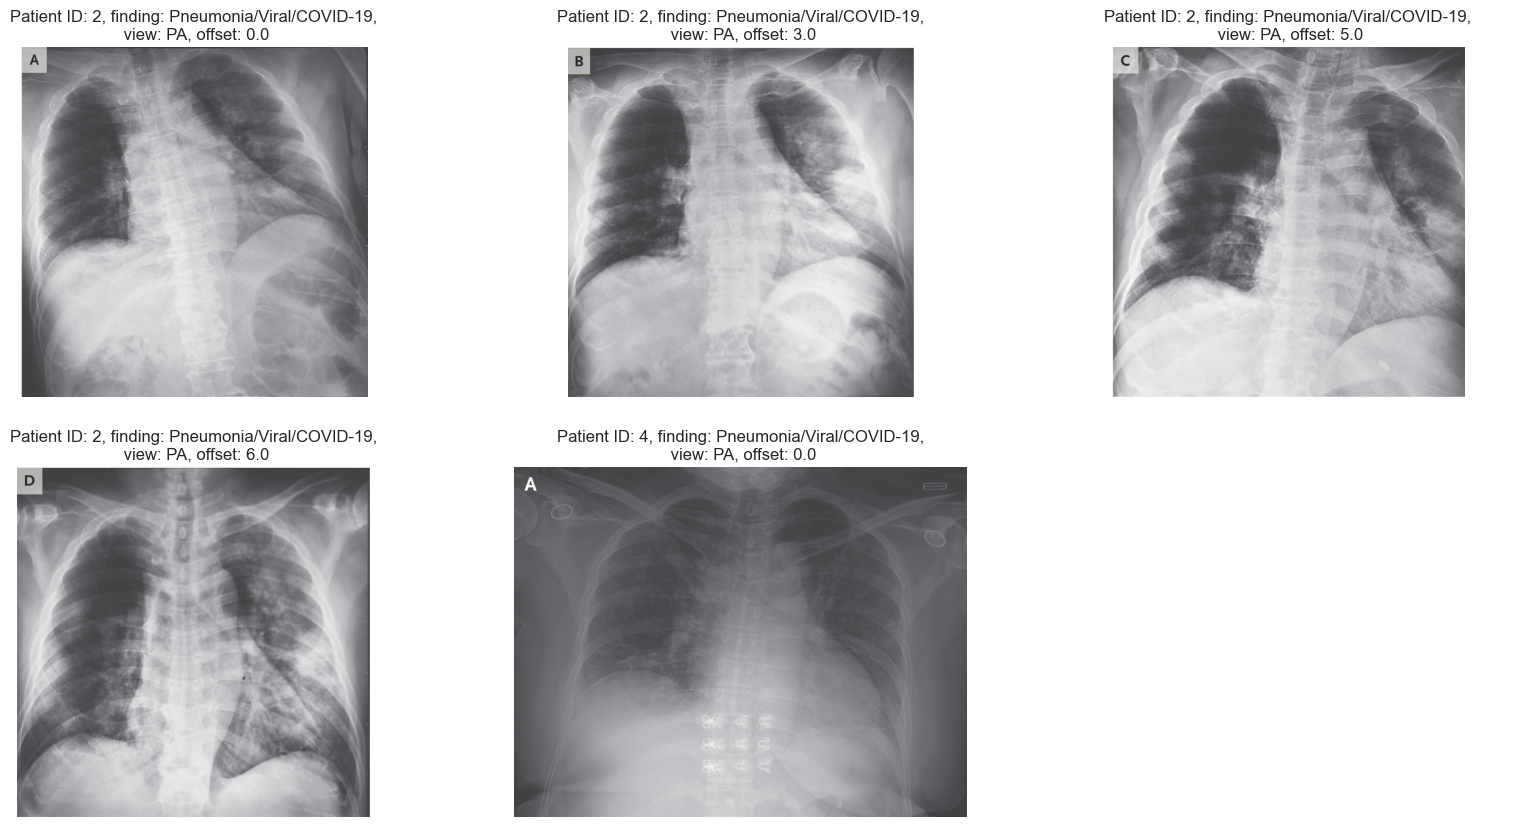

In [131]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))  # Create a 2x3 grid of subplots
axes = axes.flatten()  # Make it easy to index with a flat loop

for i, (_, case) in enumerate(covid_metadata.head(5).iterrows()):
    print(f"Processing image {i} → {case['filename']}")
    image_path = covid_images_path / case["filename"]
    image = plt.imread(image_path)
    print("Image shape:", image.shape)

    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(
        "Patient ID: {0}, finding: {1},\n view: {2}, offset: {3}".format(
            case["patientid"], case["finding"], case["view"], case["offset"]
        )
    )
    axes[i].axis("off")

# Hide any unused subplot (e.g., the 6th one if you only show 5 images)
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.show()

#### Filter Covid-19 Dataset
Write your own code to filter the metadata dataframe to contain only posteroanterior - "PA" (back-to-front) views.

Return a dataframe that contains finding/full filepath as in the following figure:
<table>
  <tr>
    <th></th>
    <th>finding</th>
    <th>filepath</th>
  </tr>
  <tr>
    <td>0</td>
    <td>Pneumonia/Viral/COVID-19</td>
    <td>some/file/path</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Pneumonia/Viral/COVID-19</td>
    <td>another/file/path</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pneumonia/Viral/SARS</td>
    <td>some/other/file/path</td>
  </tr>
    <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
        <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
       <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
        <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
       <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
       <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
        <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
</table>

In [132]:
# Initialize an empty list to collect rows
filtered_entries = []

for _, entry in covid_metadata.iterrows():
    if entry['view'] != "PA":
        continue
    filepath = f"covid-chestxray-dataset/{entry['folder']}/{entry['filename']}"
    filtered_entries.append({
        "finding": entry['finding'],
        "filepath": filepath
    })

# Create the DataFrame after filtering
filtered_db = pd.DataFrame(filtered_entries)

# Show new dataframe
filtered_db.head(30)

,finding,filepath
0,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/auntminnie-a-20...
1,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/auntminnie-b-20...
2,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/auntminnie-c-20...
3,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/auntminnie-d-20...
4,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/nejmc2001573_f1...
5,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/nejmc2001573_f1...
6,Pneumonia,covid-chestxray-dataset/images/ARDSSevere.png
7,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/lancet-case2a.jpg
8,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/lancet-case2b.jpg
9,Pneumonia/Viral/SARS,covid-chestxray-dataset/images/SARS-10.1148rg....


Filter your dataframe so it contains only COVID-19 cases:

In [133]:
filtered_db_covid = filtered_db[filtered_db["finding"] == "Pneumonia/Viral/COVID-19"]
print(filtered_db_covid.shape)
# Show new dataframe
filtered_db_covid.head(30)

(196, 2)


,finding,filepath
0,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/auntminnie-a-20...
1,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/auntminnie-b-20...
2,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/auntminnie-c-20...
3,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/auntminnie-d-20...
4,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/nejmc2001573_f1...
5,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/nejmc2001573_f1...
7,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/lancet-case2a.jpg
8,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/lancet-case2b.jpg
12,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/1-s2.0-S0140673...
13,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/nCoV-radiol.202...


#### Train Test Split
split the data into train and test data.

In [134]:
from sklearn.model_selection import train_test_split
seed=323
X = filtered_db_covid['filepath']  # features
Y = filtered_db_covid['finding']   # target

# Split: 60% train,20% validation, 20% test
# Step 1: Split into 80% train+val and 20% test
X_temp_covid, X_test_covid, Y_temp_covid, Y_test_covid = train_test_split(X, Y, test_size=0.1, random_state=seed, stratify=Y)

# Step 2: Split the 80% into 60% train and 20% val
X_train_covid, X_val_covid, Y_train_covid, Y_val_covid = train_test_split(X_temp_covid, Y_temp_covid, test_size=0.22, random_state=seed, stratify=Y_temp_covid)

print(f"Train: {X_train_covid.shape}, Validation: {X_val_covid.shape}, Test: {X_test_covid.shape}")

Train: (137,), Validation: (39,), Test: (20,)


### Load Pneumonia and Normal chest X-Ray

This dataset contains 5,856 validated Chest X-Ray images. The images are split into a training set and a testing set of independent patients. Images are labeled as (disease:NORMAL/BACTERIA/VIRUS)-(randomized patient ID)-(image number of a patient).


For more information [chest X-Ray](https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images)

##### Installing the [Kaggle API](https://github.com/Kaggle/kaggle-api) in Colab

In [ ]:
# !pip install kaggle

##### Authenticating with Kaggle using kaggle.json

Navigate to https://www.kaggle.com. Then go to the [Account tab of your user profile](https://www.kaggle.com/me/account) and select Create API Token. This will trigger the download of kaggle.json, a file containing your API credentials.

Then run the cell below to upload kaggle.json to your Colab runtime.

##### Using the Kaggle API

For a more complete list of what you can do with the API, visit https://github.com/Kaggle/kaggle-api.

##### Downloading Pneumonia and Normal chest X-Ray dataset

In [ ]:
import kaggle
!kaggle datasets download "tolgadincer/labeled-chest-xray-images"

In [ ]:
import zipfile
with zipfile.ZipFile("labeled-chest-xray-images.zip", 'r') as zip_ref:
    zip_ref.extractall("chest_xray_data")

##### Create Train and Test DataFrames
Create Train and Test DataFrames for the NORMAL/BACTERIA catagories using Pandas Dataframe (from the Pneumonia catgory take only the bacteria subcatagory and filter out the anything else from this catgory). Be sure it is of the same format of the covid 19 dataframe:
<table>
  <tr>
    <th></th>
    <th>finding</th>
    <th>filepath</th>
  </tr>
  <tr>
    <td>0</td>
    <td>NORMAL</td>
    <td>some/file/path</td>
  </tr>
  <tr>
    <td>1</td>
    <td>BACTERIA</td>
    <td>another/file/path</td>
  </tr>
    <tr>
    <td>2</td>
    <td>NORMAL</td>
    <td>some/other/file/path</td>
  </tr>
    <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
        <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
       <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
        <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
       <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
       <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
        <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
</table>

In [135]:
def create_db(path):
    entries = []
    for folder in path.iterdir():
        for image in folder.iterdir():
            if not (image.name.startswith("NORMAL") or image.name.startswith("BACTERIA")):
                continue
            else:
                category = "NORMAL" if image.name.startswith("NORMAL") else "BACTERIA"
                #filepath = str(folder / image.name)  # You already have the full path from folder
                filepath= str(folder).replace("\\", "/") +"/" + str(image.name)
                entries.append({
                    "finding": category,
                    "filepath": filepath
                })
    return pd.DataFrame(entries)


train_folder = Path("chest_xray_data/chest_xray/train")
test_folder = Path("chest_xray_data/chest_xray/test")

train_db_chest = create_db(train_folder)
test_db_chest = create_db(test_folder)


X_test_chest = test_db_chest['filepath']  # features
Y_test_chest = test_db_chest['finding'] # target

X_temp_chest = train_db_chest['filepath']  # features
Y_temp_chest = train_db_chest['finding'] # target

X_train_chest, X_val_chest, Y_train_chest, Y_val_chest = train_test_split(X_temp_chest, Y_temp_chest, test_size=0.20, random_state=seed)



## Create a full dataset





concatenate the dataframes into one 3 dataframes: Test, Train, Validation

In [152]:
print(X_train_chest.shape, Y_train_chest.shape)
print(X_val_chest.shape, Y_val_chest.shape)
print(X_test_chest.shape, Y_test_chest.shape)

print(X_train_covid.shape, Y_train_covid.shape)
print(X_val_covid.shape, Y_val_covid.shape)
print(X_test_covid.shape, Y_test_covid.shape)

X_train_combined = pd.concat([X_train_chest, X_train_covid], ignore_index=True)
Y_train_combined = pd.concat([Y_train_chest, Y_train_covid], ignore_index=True)

X_val_combined = pd.concat([X_val_chest, X_val_covid], ignore_index=True)
Y_val_combined = pd.concat([Y_val_chest, Y_val_covid], ignore_index=True)

X_test_combined = pd.concat([X_test_chest, X_test_covid], ignore_index=True)
Y_test_combined = pd.concat([Y_test_chest, Y_test_covid], ignore_index=True)

# Print shapes to confirm
print("Train:", X_train_combined.shape, Y_train_combined.shape)
print("Validation:", X_val_combined.shape, Y_val_combined.shape)
print("Test:", X_test_combined.shape, Y_test_combined.shape)


(3109,) (3109,)
(778,) (778,)
(476,) (476,)
(137,) (137,)
(39,) (39,)
(20,) (20,)
Train: (3246,) (3246,)
Validation: (817,) (817,)
Test: (496,) (496,)


For each dataframe convert findings from string to numeric classes, using the following dictionary:



In [161]:
finding_to_label = {'NORMAL':0,
 'BACTERIA':1,
 'Pneumonia/Viral/COVID-19':2}
label_to_finding = {v: k for k, v in finding_to_label.items()}

Y_train_combined.map(finding_to_label)
Y_val_combined.map(finding_to_label)
Y_test_combined.map(finding_to_label)
print(Y_train_combined.shape, Y_val_combined.shape, Y_test_combined.shape)

print(Y_test_combined[436])

(3246,) (817,) (496,)
1


## 1.2 Exlpore the data

### a. Show Data Statistics
Plot a histogram of the data and explain your results

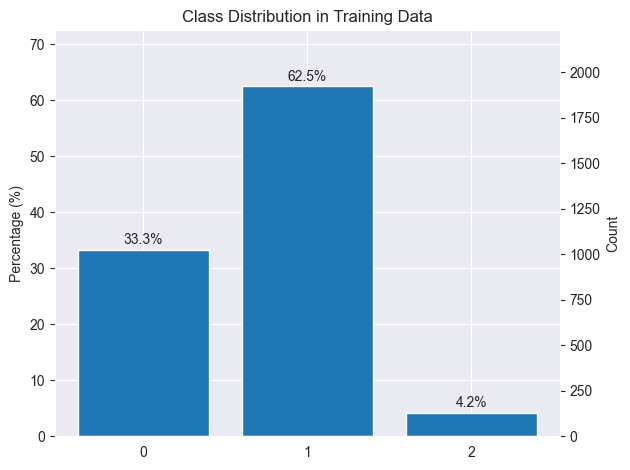

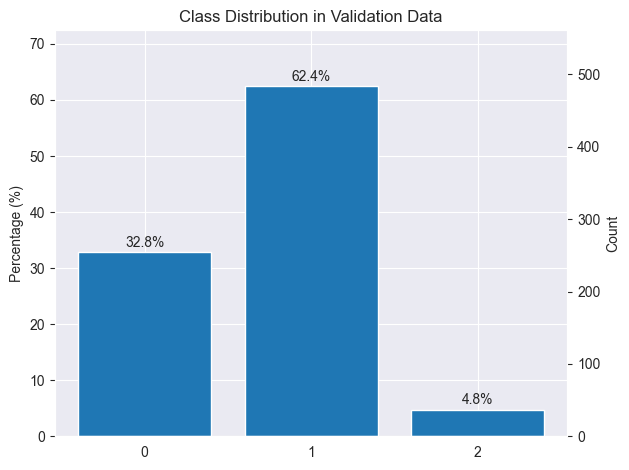

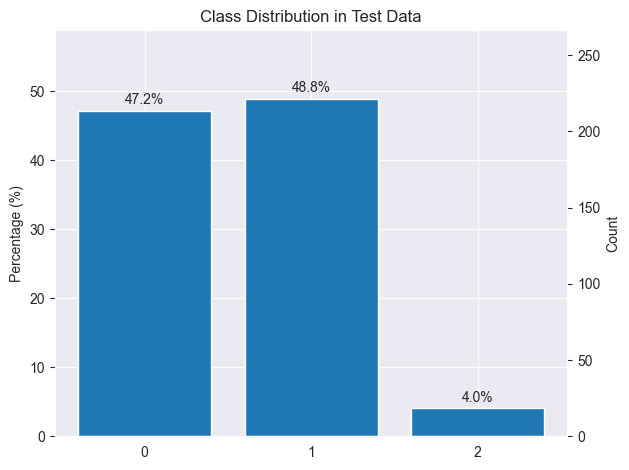

In [162]:
def plot_categories_histogram(series, header):
    counts = series.value_counts().sort_index()
    percentages = counts / counts.sum() * 100

    fig, ax1 = plt.subplots()

    # Plot percentage bars on primary y-axis (left)
    bars = ax1.bar(counts.index.astype(str), percentages)
    ax1.set_ylabel("Percentage (%)")
    ax1.set_ylim(0, max(percentages) + 10)
    ax1.set_title("Class Distribution in " + header)

    # Add percentage labels on top of bars
    for i, (count, pct) in enumerate(zip(counts, percentages)):
        ax1.text(i, pct + 1, f"{pct:.1f}%", ha='center')

    # Secondary y-axis for absolute counts (right)
    ax2 = ax1.twinx()
    ax2.set_ylabel("Count")
    ax2.set_ylim(0, max(counts) * 1.1)  # Match relative scaling

    plt.grid(axis='y')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_categories_histogram(Y_train_combined, "Training Data")
plot_categories_histogram(Y_val_combined, "Validation Data")
plot_categories_histogram(Y_test_combined, "Test Data")


**Fill your answers here:**



### b. Explore the images
Show some example images from each catagory and explain biases or corruptions in the images.

explain how to avoid those biases and corruptions

torch.Size([1, 224, 224])
(1311, 1866)
(925, 1240)
(1336, 1520)
(856, 1040)
(776, 1000)
(920, 920)
(1395, 1205, 3)
(1185, 1161, 4)


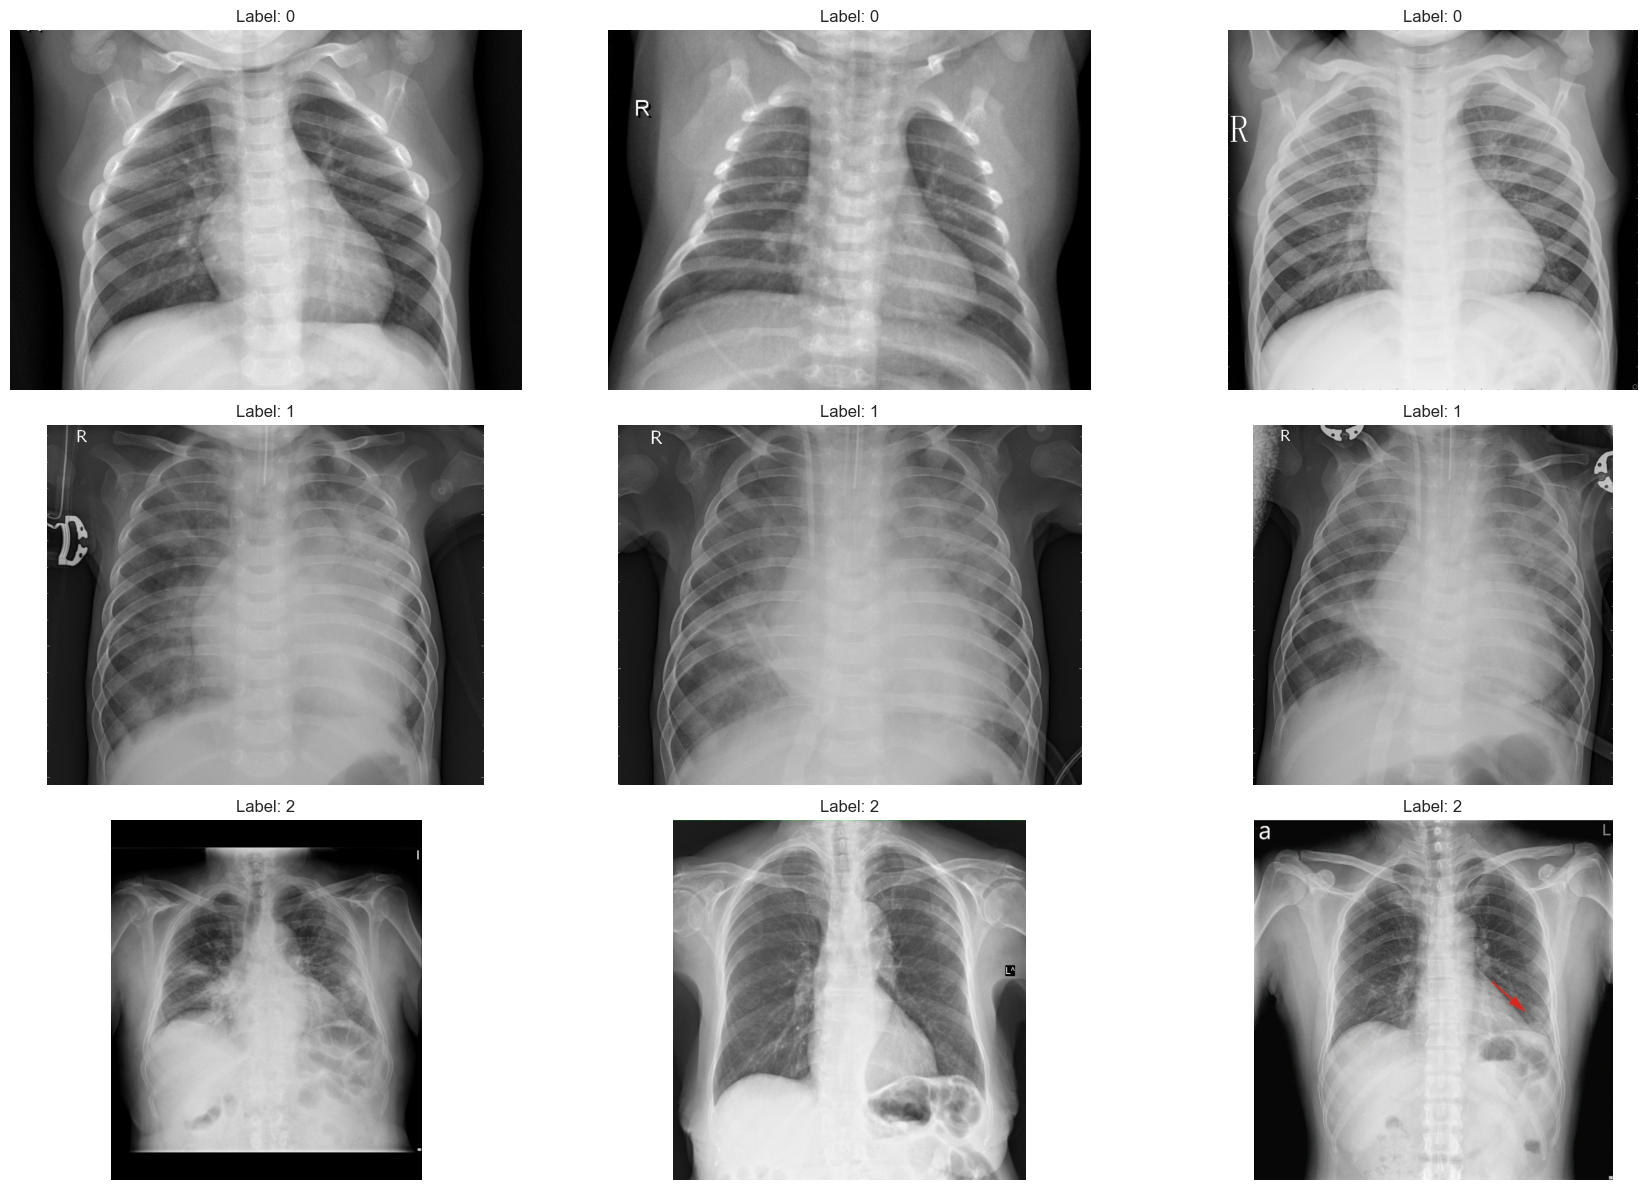

In [171]:
# Group file paths by label
grouped_samples = {}
for path, label in zip(X_test_combined, Y_test_combined):
    grouped_samples.setdefault(label, []).append(path)

# Create a 3x3 subplot grid (3 images × 3 categories)
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

# Flatten labels so we can access label names if needed
label_names = {0: "NORMAL", 1: "BACTERIA", 2: "Pneumonia/Viral/COVID-19"}

plot_idx = 0
for label in sorted(grouped_samples.keys()):
    samples = grouped_samples[label][5:8]  # Take first 3 images from this class
    for path in samples:
        print(image.shape)
        image = mpimg.imread(path)
        axes[plot_idx].imshow(image, cmap='gray')
        axes[plot_idx].set_title(f"Label: {label}", fontsize=12)
        axes[plot_idx].axis("off")
        plot_idx += 1

# Turn off any unused axes
for i in range(plot_idx, len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()

# Images not in the same size
# Some images has more dimensions than others
# Images not in the same brightness maybe?
# Some images have text written or present tools
# All images should be grayscaled
# some images has a frame - can use random crop to try eliminating this

# 2. Dealing with imbalanced data - General code - a







In [179]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
import torch.nn as nn
from scipy.ndimage import gaussian_filter1d
import datetime
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchmetrics.classification import MulticlassF1Score


class MyNet(nn.Module):
    def __init__(self, classes_count,dropout=False):
        super(MyNet, self).__init__()
        self.dropout = dropout
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)  # in: 224X224x1, out: 244X244X16
        self.conv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3,
                                padding=1)  # in: 224X224X16, out: 244X244X32
        self.mp_1 = nn.MaxPool2d(kernel_size=2, stride=2)  # in: 224X224X32, out: 112X112X32
        self.conv_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,
                                padding=1)  # in: 112X112X32, out: 112X112X64
        self.linear_1 = nn.Linear(64*56*56, 300)
        self.relu_1 = nn.ReLU()
        self.linear_2 = nn.Linear(300, classes_count)
        self.sm_1 = nn.Softmax(dim=1)
        self.dropout_fc = nn.Dropout(p=0.05)

    def forward(self, x):
        out = self.relu_1(self.conv_1(x))
        # input [B, 1, 224, 224]
        # output [B, 16, 224, 224]

        if self.dropout:
            out = self.dropout_fc(out)

        out = self.relu_1(self.conv_2(out))
        # input:  [B, 16, 224, 224]
        # output: [B, 32, 224, 224]

        if self.dropout:
            out = self.dropout_fc(out)

        out = self.mp_1(out)
        # MaxPool: [B, 32, 224, 224] → [B, 32, 112, 112]

        if self.dropout:
            out = self.dropout_fc(out)

        out = self.relu_1(self.conv_3(out))
        # input:  [B, 32, 112, 112]
        # output: [B, 64, 112, 112]

        out = self.mp_1(out)
        if self.dropout:
            out = self.dropout_fc(out)
        # MaxPool: [B, 64, 112, 112] → [B, 64, 56, 56]


        out = out.reshape(out.size(0), -1)
        out = self.relu_1(self.linear_1(out))

        if self.dropout:
            out = self.dropout_fc(out)

        out = self.linear_2(out)
        return out

class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')  # or 'L' for grayscale
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

def plot_train_progress(train_losses, validation_losses, secondary_axes=True):
    assert(len(train_losses) == len(validation_losses))
    x1 = np.arange(len(train_losses))
    validation_x_values = x1[~np.isnan(validation_losses)]
    validation_y_values = np.array(validation_losses)[~np.isnan(validation_losses)]

    filtered = gaussian_filter1d(train_losses, sigma=2)

    fig, ax = plt.subplots()  # Changed 'fix' to 'fig' for clarity
    ax.plot(x1, filtered, label='Train Loss', linestyle="solid", color="blue")
    ax.plot(validation_x_values, validation_y_values, linestyle='solid', color="red", zorder=4, label='Validation Loss')
    ax.set_xlabel("Mini Batch")
    ax.set_ylabel("Loss")
    ax.legend()
    ax.set_title("Train vs. Validation Loss Progress")

    if secondary_axes:
        epoch_numbers = np.arange(0, len(validation_x_values) + 1)
        validation_x_values_with_0 = np.insert(validation_x_values, 0, 0)
        ax2 = ax.twiny()  # twin x-axis
        ax2.set_xlim(ax.get_xlim())  # align the secondary x-axis with the primary
        ax2.set_xticks(validation_x_values_with_0)
        ax2.set_xticklabels(epoch_numbers)
        ax2.set_xlabel("Epoch")


    # Adjust layout so nothing is clipped
    plt.tight_layout()
    filename = f"image_progress_{datetime.datetime.now()}.png".replace('-', '_').replace(':', '_').replace(' ', "_")
    plt.savefig(filename, bbox_inches='tight')
    plt.show()

def plot_conf_matrix_numbers(all_labels, all_predicted):
    sklrn_conf_mat = confusion_matrix(np.array(all_labels), np.array(all_predicted))
    normalized_conf_mat = sklrn_conf_mat.astype('float') / sklrn_conf_mat.sum(axis=1)[:, np.newaxis]

    sns.heatmap(sklrn_conf_mat, annot=True, fmt="d", cmap="Greens", xticklabels=range(CLASSES_COUNT),
                yticklabels=range(CLASSES_COUNT))
    plt.xlabel("Predictaded")
    plt.ylabel("True Labels")
    plt.title("Test Results: Confusion Matrix")
    plt.savefig(
        f"confusion_matrix_{datetime.datetime.now()}.png".replace('-', '_').
        replace(':', '_').replace(' ', "_"))
    plt.show()

def plot_conf_matrix(all_labels, all_predicted):
    sklrn_conf_mat = confusion_matrix(np.array(all_labels), np.array(all_predicted))
    normalized_conf_mat = sklrn_conf_mat.astype('float') / sklrn_conf_mat.sum(axis=1)[:, np.newaxis]

    sns.heatmap(normalized_conf_mat, annot=True, fmt=".3f", cmap="Greens", xticklabels=range(CLASSES_COUNT),
                yticklabels=range(CLASSES_COUNT))
    plt.xlabel("Predictaded")
    plt.ylabel("True Labels")
    plt.title("Test Results: Confusion Matrix")
    plt.savefig(
        f"confusion_matrix_{datetime.datetime.now()}.png".replace('-', '_').
        replace(':', '_').replace(' ', "_"))
    plt.show()

def plot_f1_scores(all_predicted, all_labels):
    f1 = MulticlassF1Score(num_classes=CLASSES_COUNT, average=None)
    f1_score = f1(torch.tensor(all_predicted), torch.tensor(all_labels))
    class_names = [str(i) for i in range(CLASSES_COUNT)]
    plt.figure(figsize=(8, 5))
    plt.bar(class_names, f1_score, alpha=0.7, edgecolor='black')
    plt.xlabel("Classes")
    plt.ylabel("F1 Score")
    plt.title(f"F1 Score per Class. Macro Value:{np.average(f1_score):.4f}")
    for i, v in enumerate(f1_score):
        plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=12, fontweight='bold')
    plt.ylim(0, 1.1)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()
    print(f1_score)

def train(model:MyNet, train_loader, validation_loader, learning_rate):
    print("loading the set into train and validation")
    loss_function = nn.CrossEntropyLoss()
    steps_count = len(train_loader)
    train_losses = []
    validation_losses = []

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(EPOCHS_COUNT):
        #train the epoch
        print(f"starting epoch {epoch+1}")
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(images)
            loss = loss_function(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            validation_losses.append(np.nan)
            if i % 50 == 0:
                print(f"Epoch {epoch+1}/{EPOCHS_COUNT}, step {i+1}/{steps_count}, current loss:{loss.item()}")
        print(f"Epoch {epoch+1} / {EPOCHS_COUNT} is done. Loss:{loss.item()}")
        #validate the epoch
        with torch.no_grad():
            correct_count = 0
            total_images = 0
            acc_loss = 0
            acc_items = 0
            for i, (images, labels) in enumerate(validation_loader):
                images = images.to(DEVICE)
                labels = labels.to(DEVICE)
                outputs = model(images)
                val, predicted = torch.max(outputs.data, dim=1)
                total_images += len(images)
                correct = (predicted == labels).sum().item()
                correct_count += correct
                loss = loss_function(outputs, labels)
                batch_size = images.size(0)
                acc_loss += loss.item() * batch_size
                acc_items += batch_size
                del images, labels, outputs
            val_loss = (acc_loss / acc_items)
            validation_losses[-1] = val_loss
            print(f"validation accuracy ratio: {correct_count / total_images}")

    plot_train_progress(train_losses, validation_losses)

def test(model: MyNet, test_loader):
    with torch.no_grad():
        correct_cout = 0
        total_count = 0
        all_predicted = []
        all_labels = []
        for images, labels in test_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(images)
            vals, predicted = torch.max(outputs.data, 1)
            all_predicted += predicted.tolist()
            all_labels += labels.tolist()
            total_count += len(labels)
            correct_cout += (predicted == labels).sum().item()
            del images, labels, outputs
        print(f"Test results: accuracy of {correct_cout / total_count}")
        plot_conf_matrix(all_labels, all_predicted)
        plot_conf_matrix_numbers(all_labels, all_predicted)
        plot_f1_scores(all_predicted, all_labels)

SEIF 2 data and parameters definitions

Device used for learning: cuda


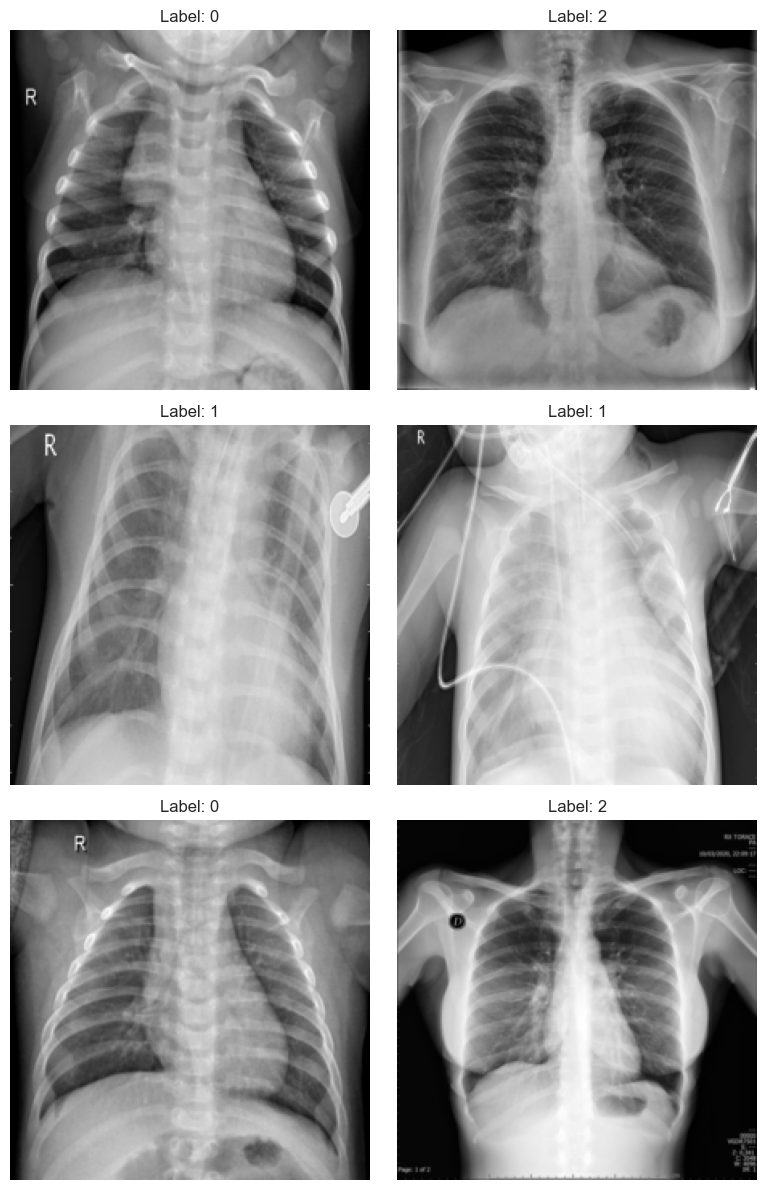

In [180]:
from torch.utils.data import DataLoader
import random
LEARNING_RATE = 0.001
EPOCHS_COUNT = 5
BATCH_SIZE = 16
CLASSES_COUNT=3

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device used for learning: {DEVICE}")

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),  # resize to match model input
    transforms.RandomApply([transforms.RandomResizedCrop(size=(224, 224), scale=(0.7, 1.0))],p=0.2),
    transforms.ToTensor(),          # convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # for grayscale; use 3 values for RGB
])


train_dataset = ImageDataset(X_train_combined, Y_train_combined, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

validation_dataset = ImageDataset(X_val_combined, Y_val_combined, transform=transform)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = ImageDataset(X_test_combined, Y_test_combined, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Initialize counters for each label
label_counts = {0: 0, 1: 0, 2: 0}
target_count = 2  # How many images per label to display

# Store images to display together
images_to_display = []

while any(count < target_count for count in label_counts.values()):
    image, label = train_dataset[random.randint(0, len(train_dataset)-1)]
    label = int(label)  # make sure label is an int, not tensor
    if label in label_counts and label_counts[label] < target_count:
        images_to_display.append((image, label))
        label_counts[label] += 1

# Display all images in a grid
fig, axes = plt.subplots(3, 2, figsize=(8, 12))
axes = axes.flatten()

for i, (image, label) in enumerate(images_to_display):
    axes[i].imshow(image.squeeze(), cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

SEIF 2 - b - train on the original data

loading the set into train and validation
starting epoch 1
Epoch 1/5, step 1/203, current loss:1.103342890739441
Epoch 1/5, step 51/203, current loss:0.11513282358646393
Epoch 1/5, step 101/203, current loss:0.05150170251727104
Epoch 1/5, step 151/203, current loss:0.28457972407341003
Epoch 1/5, step 201/203, current loss:0.35167205333709717
Epoch 1 / 5 is done. Loss:0.25857993960380554
validation accuracy ratio: 0.9277845777233782
starting epoch 2
Epoch 2/5, step 1/203, current loss:0.3331608474254608
Epoch 2/5, step 51/203, current loss:0.12997236847877502
Epoch 2/5, step 101/203, current loss:0.09176871180534363
Epoch 2/5, step 151/203, current loss:0.14973504841327667
Epoch 2/5, step 201/203, current loss:0.23934146761894226
Epoch 2 / 5 is done. Loss:0.0802384465932846
validation accuracy ratio: 0.9608323133414932
starting epoch 3
Epoch 3/5, step 1/203, current loss:0.0753447562456131
Epoch 3/5, step 51/203, current loss:0.33170753717422485
Epoch 3/5, step 101/203, current loss:0.3

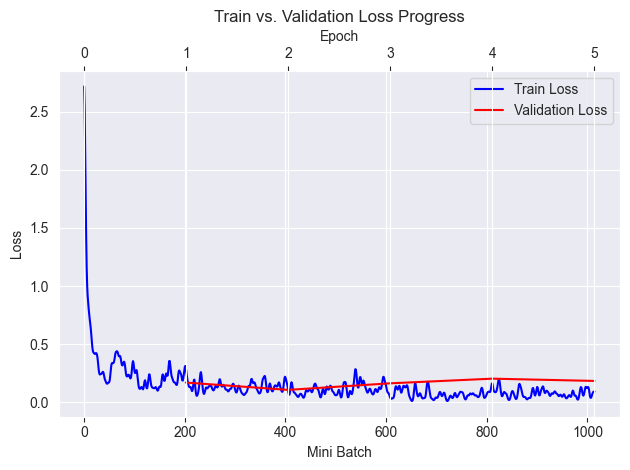

In [183]:
model2b = MyNet(CLASSES_COUNT).to(DEVICE)
train(model2b, train_loader, validation_loader, LEARNING_RATE)

testing...
Test results: accuracy of 0.8568548387096774


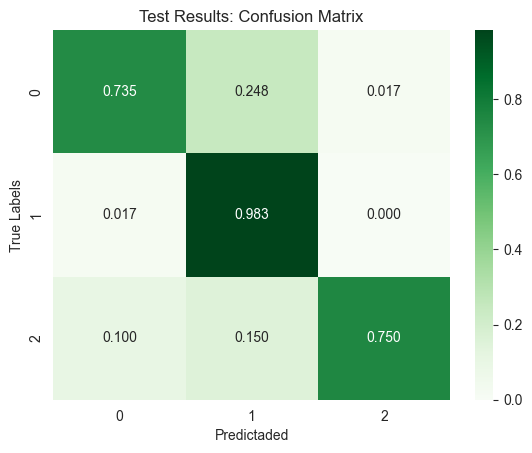

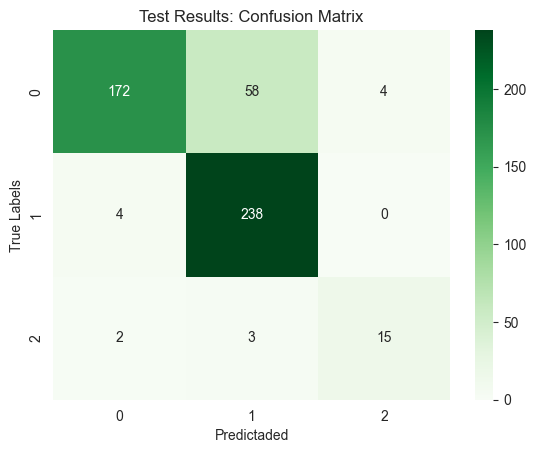

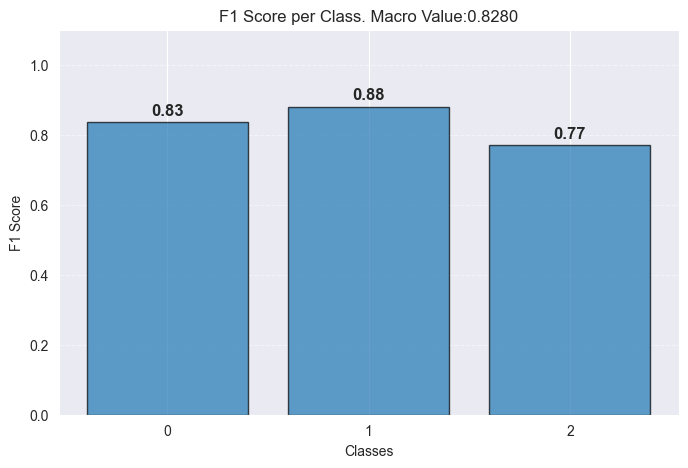

tensor([0.8350, 0.8799, 0.7692])
done


In [184]:
print("testing...")
test(model2b,test_loader)
print("done")

Seif 2 - c undersampling

In [186]:
import numpy as np
from collections import defaultdict
from sklearn.utils import resample

random_state = 11
# Combine X and Y
train_data = list(zip(X_train_combined, Y_train_combined))

# Group data by class
class_dict = defaultdict(list)
for x, y in train_data:
    class_dict[y].append((x, y))

# Find minimum class size
min_class_size = min(len(samples) for samples in class_dict.values())

# Undersample each class to the min size
balanced_data = []
for cls_samples in class_dict.values():
    balanced_data.extend(resample(cls_samples, replace=False, n_samples=min_class_size, random_state=random_state))

# Shuffle the balanced data
np.random.shuffle(balanced_data)

# Unzip to get X and Y
X_train_balanced, Y_train_balanced = zip(*balanced_data)

# Create datasets and loaders
train_dataset = ImageDataset(X_train_balanced, Y_train_balanced, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)



loading the set into train and validation
starting epoch 1
Epoch 1/5, step 1/26, current loss:1.102964997291565
Epoch 1 / 5 is done. Loss:0.09675474464893341
validation accuracy ratio: 0.8763769889840881
starting epoch 2
Epoch 2/5, step 1/26, current loss:0.09355754405260086
Epoch 2 / 5 is done. Loss:0.3908802270889282
validation accuracy ratio: 0.8200734394124847
starting epoch 3
Epoch 3/5, step 1/26, current loss:0.13702324032783508
Epoch 3 / 5 is done. Loss:0.6264472603797913
validation accuracy ratio: 0.9082007343941249
starting epoch 4
Epoch 4/5, step 1/26, current loss:0.16771933436393738
Epoch 4 / 5 is done. Loss:0.11745023727416992
validation accuracy ratio: 0.9020807833537332
starting epoch 5
Epoch 5/5, step 1/26, current loss:0.025841591879725456
Epoch 5 / 5 is done. Loss:0.016958924010396004
validation accuracy ratio: 0.9155446756425949


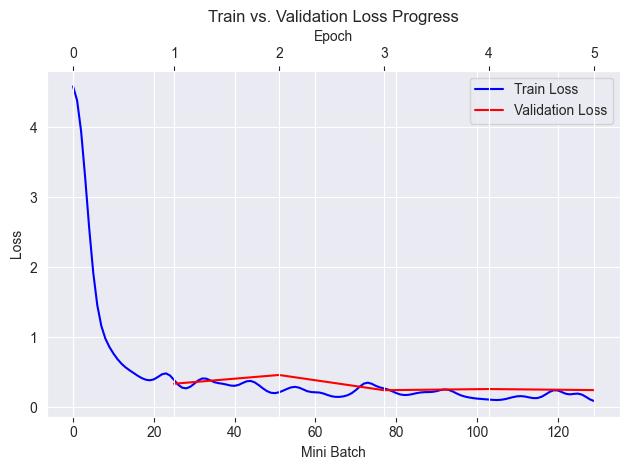

In [188]:
model = MyNet(CLASSES_COUNT).to(DEVICE)
train(model, train_loader, validation_loader, LEARNING_RATE)


testing...
Test results: accuracy of 0.8084677419354839


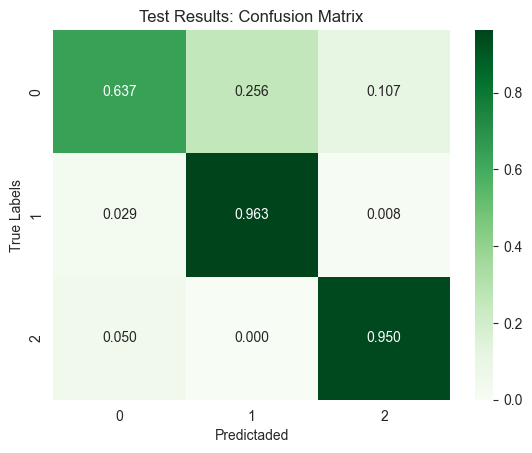

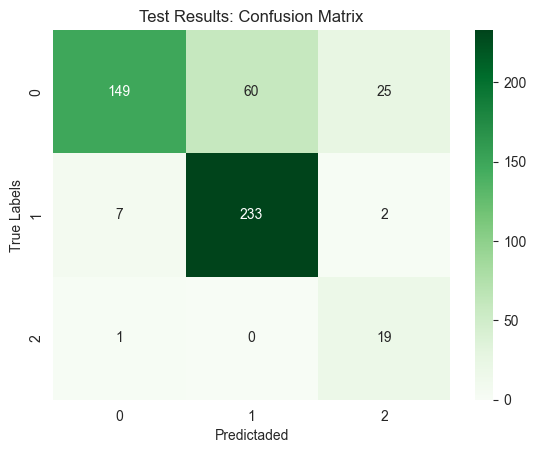

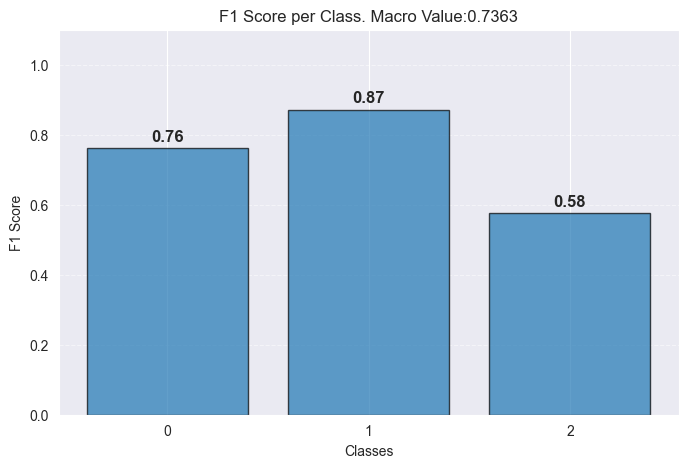

tensor([0.7621, 0.8710, 0.5758])
done


In [189]:
print("testing...")
test(model,test_loader)
print("done")

seif 2 - c - over sampling

In [319]:
class AugementedImageDataset(Dataset):
    def __init__(self, image_paths, labels,minority_classes, transform_regular, transform_augmented):
        self.image_paths = image_paths
        self.labels = labels
        self.minority_classes = set(minority_classes)
        self.transform_regular = transform_regular
        self.transform_augmented = transform_augmented

        # Group samples by class
        self.class_to_indices = {c: [] for c in set(labels)}
        for idx, label in enumerate(labels):
            self.class_to_indices[label].append(idx)

        max_class_count = max(len(idxs) for idxs in self.class_to_indices.values())


        # Generate balanced index list
        self.balanced_indices = []
        for cls, indices in self.class_to_indices.items():
            if cls in self.minority_classes:
                oversample_count = max_class_count - len(indices)
                repeated = random.choices(indices, k=oversample_count)
                self.balanced_indices.extend(indices + repeated)
            else:
                self.balanced_indices.extend(indices)

    def __len__(self):
        return len(self.balanced_indices)

    def __getitem__(self, idx):
        true_idx = self.balanced_indices[idx]
        image = Image.open(self.image_paths[true_idx]).convert('RGB')  # or 'L' for grayscale
        label = self.labels[true_idx]

        if label in self.minority_classes:
            image = self.transform_augmented(image)
        else:
            image = self.transform_regular(image)

        return image, label

In [320]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),  # resize to match model input
    transforms.RandomApply([transforms.RandomResizedCrop(size=(224, 224), scale=(0.7, 1.0))],p=0.2),
    transforms.ToTensor(),          # convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # for grayscale; use 3 values for RGB
])

transform_augmented = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # ensures grayscale
    transforms.Resize((224, 224)),  # resize to fixed size

    # Random augmentations
    transforms.RandomApply([
        transforms.RandomResizedCrop(size=(224, 224), scale=(0.6, 1.0))
    ],p=0.5),

    transforms.RandomApply([
        transforms.RandomRotation(degrees=(-10, 10))
    ], p=0.5),

    transforms.RandomApply([
        transforms.ColorJitter(contrast=(0.7, 1.3))  # safe contrast adjustment
    ], p=0.5),

    # Optional, only if left-right orientation doesn’t matter in your data:
    transforms.RandomApply([
        transforms.RandomHorizontalFlip()
    ], p=0.5),

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


dataset = AugementedImageDataset(
    image_paths=X_train_combined,
    labels=Y_train_combined,
    transform_regular=transform,
    transform_augmented=transform_augmented,
    minority_classes=[0, 2]
)

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [300]:
total_samples = 0

for images, labels in train_loader:
    total_samples += len(labels)

In [321]:
from collections import defaultdict, Counter

# Step 1: Count how many times each original index appears in balanced_indices
index_counts = Counter(dataset.balanced_indices)

# Step 2: Filter for original indices from class 2 that were duplicated >4 times
original_target_indices = [i for i, count in index_counts.items()
                           if count > 4 and dataset.labels[i] == 2]

# Step 3: Create dictionary mapping original index to its positions in the balanced dataset
original_to_balanced_map = defaultdict(list)

for i, val in enumerate(dataset.balanced_indices):
    if val in original_target_indices:
        original_to_balanced_map[val].append(i)

# Optional: print a few entries
for original_idx, occurrences in list(original_to_balanced_map.items())[4:6]:
    print(f"Original idx {original_idx} appears at balanced dataset indices: {occurrences}")


Original idx 3113 appears at balanced dataset indices: [4060, 4215, 4369, 4706, 5174, 5369, 5485, 5848, 5877, 5952]
Original idx 3114 appears at balanced dataset indices: [4061, 4311, 4579, 4719, 5028, 5124, 5404, 5455, 6035]


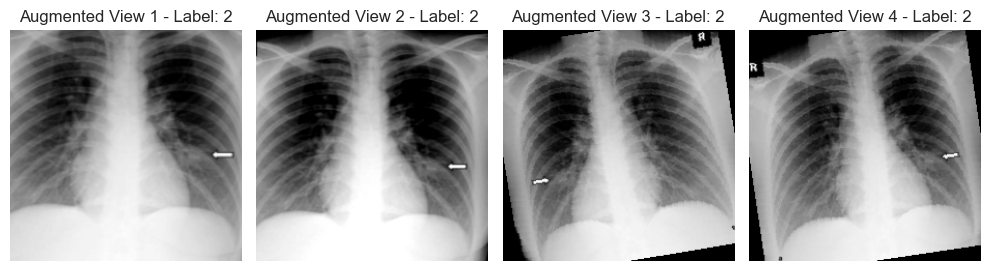

In [350]:
import matplotlib.pyplot as plt
import random

def show_image(tensor, title=None):
    image = tensor.squeeze().numpy()  # assume grayscale
    plt.imshow(image, cmap='gray')
    if title:
        plt.title(title)
    plt.axis('off')



# Fetch twice to get two versions
img1, label1 = dataset[4060]
img2, label2 = dataset[4215]  # augmentation will be different if it's a minority
img3, label3 = dataset[4369]  # augmentation will be different if it's a minority
img4, label4 = dataset[4706]  # augmentation will be different if it's a minority

# Plot side by side
plt.figure(figsize=(10, 8))
plt.subplot(1, 4, 1)
show_image(img1, title=f"Augmented View 1 - Label: {label1}")
plt.subplot(1, 4, 2)
show_image(img2, title=f"Augmented View 2 - Label: {label2}")
plt.subplot(1, 4, 3)
show_image(img3, title=f"Augmented View 3 - Label: {label3}")
plt.subplot(1, 4, 4)
show_image(img4, title=f"Augmented View 4 - Label: {label4}")
plt.tight_layout()
plt.show()

loading the set into train and validation
starting epoch 1
Epoch 1/5, step 1/381, current loss:1.097222089767456
Epoch 1/5, step 51/381, current loss:0.12416931986808777
Epoch 1/5, step 101/381, current loss:0.06598777323961258
Epoch 1/5, step 151/381, current loss:0.28794315457344055
Epoch 1/5, step 201/381, current loss:0.275325208902359
Epoch 1/5, step 251/381, current loss:0.12158782035112381
Epoch 1/5, step 301/381, current loss:0.07432737201452255
Epoch 1/5, step 351/381, current loss:0.2296844869852066
Epoch 1 / 5 is done. Loss:0.07770255208015442
validation accuracy ratio: 0.9375764993880049
starting epoch 2
Epoch 2/5, step 1/381, current loss:0.024437496438622475
Epoch 2/5, step 51/381, current loss:0.06200107932090759
Epoch 2/5, step 101/381, current loss:0.048590026795864105
Epoch 2/5, step 151/381, current loss:0.168348491191864
Epoch 2/5, step 201/381, current loss:0.008818484842777252
Epoch 2/5, step 251/381, current loss:0.012291057035326958
Epoch 2/5, step 301/381, curr

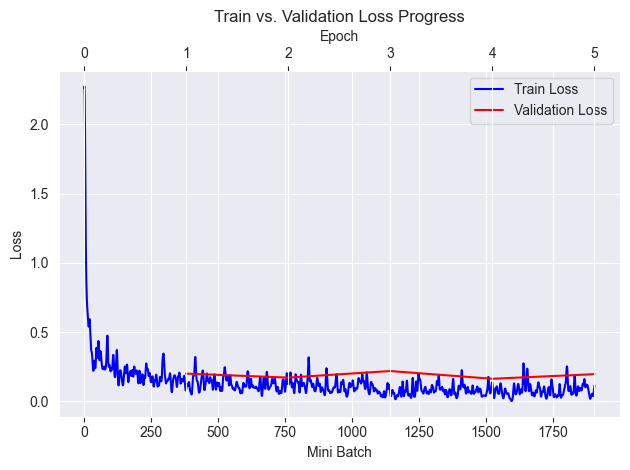

In [347]:
model = MyNet(CLASSES_COUNT).to(DEVICE)
train(model, train_loader, validation_loader, LEARNING_RATE)

testing...
Test results: accuracy of 0.8911290322580645


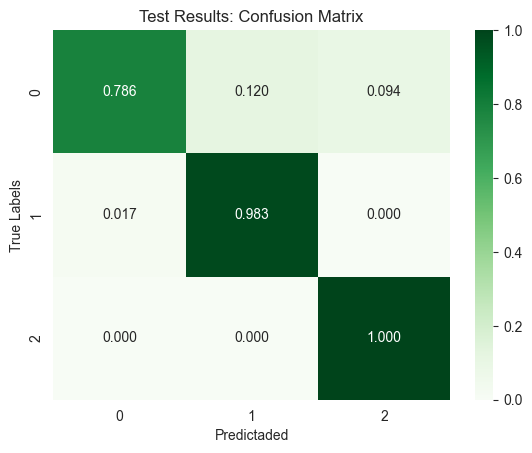

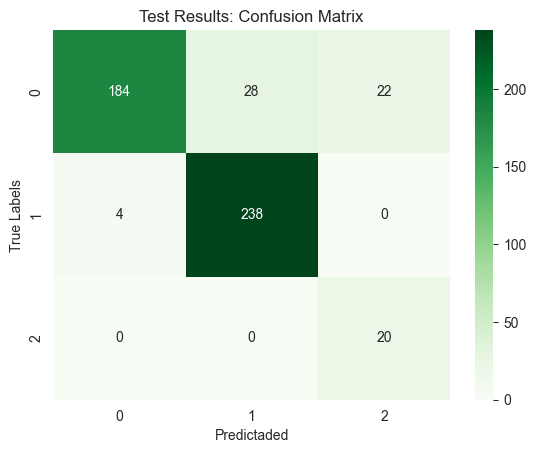

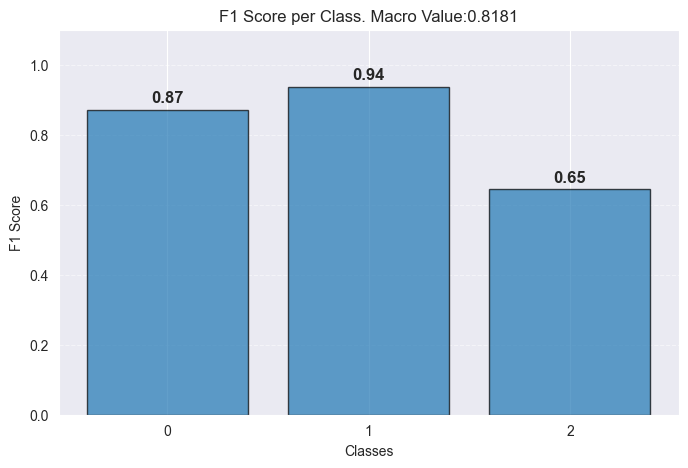

tensor([0.8720, 0.9370, 0.6452])
done


In [348]:
print("testing...")
test(model,test_loader)
print("done")

# 3. Transfer Learning


In [ ]:
### Fill in your code

# 4. t-SNE

In [ ]:
### Fill in your code